### Research and Report Hierarchical Agent Teams System

A supervisor agent's work is to route between different work nodes. But when job becomes complex or there is a large number of workers it becomes difficult for the supervisor to effectively call the correct worker node.

For such cases hierarchically distributed architecture works best. We can build this by composing different sub-graphs and creating a top-level supervisor along with mid-level supervisors.

In [25]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

openai_llm = ChatOpenAI(model='gpt-4o-mini')

quen_llm = ChatGroq(model='qwen/qwen3-32b')

llama_llm = ChatGroq(model='deepseek-r1-distill-llama-70b')

## Building Research Team Tools

In [2]:
tavily_tool = TavilySearchResults(max_results = 5)

In [3]:
from typing import Annotated, TypedDict, Literal, Any
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import MessagesState, MessageGraph, START,END, StateGraph
from langgraph.types import Command


class State(MessagesState):
    next: str
    
def make_supervisor_node(llm:BaseChatModel, members:list[str], system_prompt:str) ->str:
    
    members_list= ['FINISH']+members
    
    class RouterSupervisor(TypedDict):
        next: Literal[*members_list]
        
    def supervisor_node(state:State) -> Command[Literal[*members,"__end__"]]:
        print('<-- Supervisor Node -->')
        message = [{'role':'system','content':system_prompt}]+state['messages']
        
        llm_with_structured_output = llm.with_structured_output(RouterSupervisor)
        response = llm_with_structured_output.invoke(message)
        
        goto = response['next']
        
        if goto=='FINISH':
            goto=END
        return Command(goto=goto, update={'next':goto})
    return supervisor_node

In [4]:
members = ['general_researcher','finance_researcher','medical_researcher']
system_prompt = f"""
    You are a supervisor managing a task delegation system with the following workers: {members}.

    Your job is to decide which worker should act next based on the user’s input.

    Guidelines:
    - If the message is about stocks, shares, company performance, financial comparison, or anything related to companies or markets, assign it to finance_researcher.
    - If the message is related to finance, assign finance_researcher.
    - If the message is related to medical or medicine science, assign medical_researcher.
    - If the message is related to general research, assign general_researcher.
    - Once all the tasks are completed respond with FINISH.
    - Do **not** invent tasks or assign actions unless the message clearly demands it.

    **Examples:**
    - "Compare Microsoft and Nvidia shares for today's price" → finance_researcher
    - "What is the latest on Apple stock?" → finance_researcher
    - "What are the symptoms of flu?" → medical_researcher
    - "Explain quantum computing" → general_researcher

    Each worker will return results after completing their task.
    Once all necessary tasks are completed, end the flow by responding with `FINISH`.

    Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.
"""
research_supervisor_node = make_supervisor_node(openai_llm,members,system_prompt)

#### Research Agents

##### General Research

In [5]:
from langchain import hub
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage, AIMessage


def general_research(state:State) -> Command[Literal['supervisor']]:
    print('<-- General Researcher -->')
    
    prompt = (
            "You are a **General Purpose Research Assistant**. Your primary goal is to conduct **thorough and detailed research** "
            "on a wide range of topics using the `tavily_search_results_json` tool. "
            "When presented with a query, identify the core subject and gather comprehensive information, "
            "facts, and relevant details from the web. "
            "Synthesize your findings into a well-structured and informative summary. "
            "Ensure your response is detailed, covers multiple facets of the query if applicable, and provides specific data points. "
            "Do not just list links; provide summarized content from your findings."
    )
    tavily_agent = create_react_agent(quen_llm, tools= [tavily_tool],prompt=prompt)
    
    result = tavily_agent.invoke(state)
    return Command(
        goto='supervisor',
        update={'messages':[HumanMessage(content=result['messages'][-1].content, name='general_researcher')]}
    )

##### Medical Researcher

In [6]:
from langchain_community.retrievers import PubMedRetriever
from langchain.tools.retriever import create_retriever_tool

def medical_research(state:State) -> Command[Literal['supervisor']]:
    print('<-- Medical Researcher -->')
     
    retriever = PubMedRetriever()

    medical_retriever_tool = create_retriever_tool(
        retriever=retriever,
        name = 'medical_researcher',
        description='''
        Searches and returns highly relevant, scientific information from PubMed related to user queries about medicine, 
        medical conditions, diseases, symptoms, treatments, medications, clinical trials, and medical emergencies. 
        Prioritize peer-reviewed and authoritative sources.
        '''
    )
    prompt =(
            "You are a highly specialized **Medical Research Expert**. Your sole purpose is to conduct "
            "**in-depth research on medical topics** using the `medical_pubmed_search` tool and `tavily_search_results_json` tool "
            "as supplementary. When given a medical query, you must find detailed, accurate, and evidence-based information. "
            "Focus on symptoms, causes, treatments, prognoses, relevant studies, and drug interactions if applicable. "
            "Your response should be a comprehensive summary of your findings, presenting key facts and medical insights clearly. "
            "Avoid speculative or non-medical information."
    )
    medical_agent = create_react_agent(quen_llm, tools= [medical_retriever_tool,tavily_tool],prompt=prompt)
    
    result = medical_agent.invoke(state)
    return Command(
        goto='supervisor',
        update={'messages':[HumanMessage(content=result['messages'][-1].content, name='medical_researcher')]}
    )

##### Financial Researcher

In [7]:
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_core.prompts import PromptTemplate
import yfinance as yf

yfinance =YahooFinanceNewsTool()

@tool
def get_stock_price(ticker:str) -> str:
    '''
    Fetch the last closed price, day's open price, day's high, and day's low for a given stock ticker.
    Always use the correct ticker symbol for company names (e.g., Microsoft=MSFT, Nvidia=NVDA).
    '''
    dat = yf.Ticker(ticker)
    previous_close_price = dat.info.get('previousClose')
    previous_open_price = dat.info.get('open')
    day_high = dat.info.get('dayHigh')
    day_low = dat.info.get('dayLow')
    
    if previous_close_price is None:
        return f'Could not fetch price detail for {ticker}'
    return (f'Stock details for {ticker}: '
                f'Last Closing Price: ${previous_close_price}, '
                f'Day Open Price: ${previous_open_price}, '
                f'Day Highest: ${day_high}, '
                f'Day Lowest: ${day_low}.'
            )
    

def finance_research(state:State) -> Command[Literal['supervisor']]:
    print('<-- Finance Researcher -->')
    
    prompt = (
            "You are a highly specialized **Financial Research Expert**. Your mission is to conduct "
            "**detailed financial research and analysis** using `yahoo_finance_news` for news and `get_stock_price` for specific stock data."
            "When presented with a financial query (e.g., company performance, stock prices, market trends, financial news), "
            "you must use your tools to gather relevant data and provide a comprehensive financial report or analysis. "
            "Include specific numbers, trends, recent news, and market insights. "
            "**Make Sure**"
            "If the user provides a company name, use the correct ticker symbol (e.g., Microsoft=MSFT, Nvidia=NVDA)."
            "If a stock symbol is mentioned, always prioritize using `get_stock_price` for direct data. "
            "Synthesize your findings into a clear, factual, and actionable financial overview.\n\n"
        )
    
            
    yfinance_agent = create_react_agent(quen_llm,tools=[yfinance,get_stock_price], prompt=prompt)
    print(state)
    
    response = yfinance_agent.invoke(state)
    #print(response['messages'][-1].content)
    
    return Command(
        goto='supervisor',
        update={'messages':[HumanMessage(content=response['messages'][-1].content, name='finance_researcher')]}
    )
    
#research_supervisor_node = make_research_supervisor(quen_llm,['general_researcher','finance_researcher'])

In [8]:
## Building Research Graph

research_builder = StateGraph(State)
research_builder.add_node('supervisor', research_supervisor_node)
research_builder.add_node('general_researcher', general_research)
research_builder.add_node('finance_researcher',finance_research)
research_builder.add_node('medical_researcher', medical_research)

## Logic
research_builder.add_edge(START,'supervisor')

## Compile
research_app = research_builder.compile()

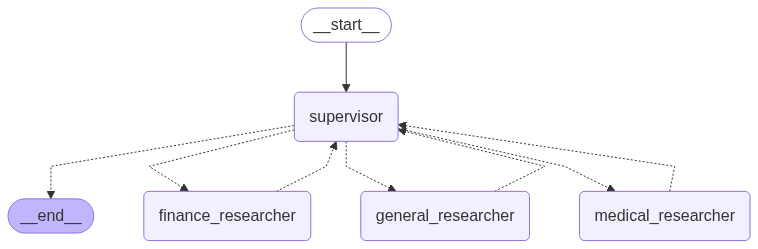

In [9]:
research_app

In [10]:
message = [HumanMessage(content="How did Nvidia stock performed today in comparision to Microsoft")]
response =  research_app.invoke({'messages':message})
print(response)

<-- Supervisor Node -->
<-- Finance Researcher -->
{'messages': [HumanMessage(content='How did Nvidia stock performed today in comparision to Microsoft', additional_kwargs={}, response_metadata={}, id='fdc91348-1837-47a6-b7ff-fbb7d0f1d566')], 'next': 'finance_researcher'}
<-- Supervisor Node -->
{'messages': [HumanMessage(content='How did Nvidia stock performed today in comparision to Microsoft', additional_kwargs={}, response_metadata={}, id='fdc91348-1837-47a6-b7ff-fbb7d0f1d566'), HumanMessage(content='**Nvidia (NVDA) vs. Microsoft (MSFT) Stock Performance Comparison (Today):**\n\n### **1. Nvidia (NVDA)**\n- **Last Closing Price**: $157.25  \n- **Day Open**: $158.35  \n- **Day High**: $160.98  \n- **Day Low**: $157.77  \n- **Intraday Performance**:  \n  - **Change (Open to Close)**: -$1.10 (-0.70%)  \n  - **Range**: $157.77 to $160.98  \n\n### **2. Microsoft (MSFT)**\n- **Last Closing Price**: $491.09  \n- **Day Open**: $493.495  \n- **Day High**: $500.12  \n- **Day Low**: $493.44  \

In [11]:
response['messages'][-1].pretty_print()

================================ Human Message =================================
Name: finance_researcher

**Nvidia (NVDA) vs. Microsoft (MSFT) Stock Performance Comparison (Today):**

### **1. Nvidia (NVDA)**
- **Last Closing Price**: $157.25  
- **Day Open**: $158.35  
- **Day High**: $160.98  
- **Day Low**: $157.77  
- **Intraday Performance**:  
  - **Change (Open to Close)**: -$1.10 (-0.70%)  
  - **Range**: $157.77 to $160.98  

### **2. Microsoft (MSFT)**
- **Last Closing Price**: $491.09  
- **Day Open**: $493.495  
- **Day High**: $500.12  
- **Day Low**: $493.44  
- **Intraday Performance**:  
  - **Change (Open to Close)**: -$2.405 (-0.49%)  
  - **Range**: $493.44 to $500.12  

### **Key Insights**:
- Both stocks closed **lower than their opening prices**, but **Microsoft outperformed Nvidia** in terms of percentage decline (-0.49% vs. -0.70%).  
- **Microsoft had a wider intraday range** ($6.68) compared to Nvidia ($3.21), reflecting higher volatility.  
- Despite a lower

#### Document Writing Team

In [26]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional,List, Annotated
from langchain_experimental.utilities import PythonREPL

dir_name = 'output_files'
os.makedirs(dir_name,exist_ok=True)

@tool
def read_document(
    file_name: Annotated[str, "File name to read the document from"],
    start: Annotated[Optional[int], 'The start line. Default is 0']=None,
    end: Annotated[Optional[int],' The end line. Default is None'] = None
) -> str:
    '''Read the specific document'''
    print('read_document')
    full_path = os.path.join(dir_name, file_name)
    with open(full_path,'r') as file:
        lines = file.readlines()
    if start is None:
        start=0
    return " ".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str,"Text content to be written into the document"],
    file_name: Annotated[str,"File name to save the document"]
) -> Annotated[str,"Path of the saved document"]:
    '''Create and save the text document'''
    
    print(f'Writing Document in {file_name}')
    file_path = os.path.join(dir_name,file_name)
    with open(file_path,'w') as file:
        file.write(content)
    return f"Document saved to {file_path}"

        
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute and generate your chart"]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    print('python_repl_tool')
    try:
        repl = PythonREPL()
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed: \n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str



<>:49: SyntaxWarning: invalid escape sequence '\`'
<>:49: SyntaxWarning: invalid escape sequence '\`'
<>:49: SyntaxWarning: invalid escape sequence '\`'
<>:49: SyntaxWarning: invalid escape sequence '\`'
C:\Users\ashut\AppData\Local\Temp\ipykernel_41508\2648976037.py:49: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed: \n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\ashut\AppData\Local\Temp\ipykernel_41508\2648976037.py:49: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed: \n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [27]:

@tool
def summarize_and_formatter(
    content: Annotated[str, "The content provided by the researcher team to be summarized and formatted into markedown format"]
)->str:
    '''Summarize and Format the content provided to you in a proper document structure (e.g., Markdown).'''
    print('summarize_and_formatter')
    
    ## Prompt for summarization
    summary_prompt = PromptTemplate(
        input_variables=["content"],
        template=(
            "You are an expert document formatter and writer. Your task is to take the following raw content "
            "and transform it into a well-structured, coherent, and detailed document in Markdown format. "
            "Include appropriate headings (e.g., #, ##), bullet points, and paragraphs to make it readable and professional. "
            "Ensure all key information from the raw content is included and presented clearly. "
            "Do NOT summarize excessively; instead, expand and organize the given information into a full document.\n\n"
            "Raw Content:\n{content}\n\n"
            "Formatted Document (in Markdown):"
        )
    )
    
    summary_chain = summary_prompt | llama_llm
    summary_content = summary_chain.invoke({'content':content}).content

    return summary_content

In [29]:
def summarizing_node(state:State) ->Command[Literal['supervisor']]:
    print('<-- Summarizer & Formatter Node -->')
    
    prompt =(
        "You are an expert formatter. Your job is to take the raw content provided by the researcher team "
        "and use the `summarize_and_formatter` tool to create a well-structured document from it. "
        "Do not ask follow-up questions. Provide the entire relevant raw content to the tool."
    )
    summarizer_agent = create_react_agent(
        quen_llm,
        tools=[summarize_and_formatter],
        prompt=prompt
    )
    
    response = summarizer_agent.invoke(state)
    
    return Command(
        goto='supervisor',
        update={'messages':[HumanMessage(content=response['messages'][-1].content, name='summarizer')]}
    )
    
def doc_writing_node(state:State) -> Command[Literal['supervisor']]:
    print('<-- Document Writing -->')
    
    prompt = (
            "You are an AI assistant specialized in saving documents. "
            "Your task is to use the `write_document` tool to save the provided formatted content to a file. "
            "Based on the content, **choose a descriptive and relevant file name ending with '.md'**. "
            "For example, if the content is about 'stock performance', a good filename would be 'stock_performance_report.md'. "
            "Do not output anything else, just the tool call.\n\n"
            "Now, make the tool call to save the document."
    )
    
    
    doc_writing_agent = create_react_agent(
        quen_llm,
        tools=[write_document],
        prompt=prompt
    )
    
    response = doc_writing_agent.invoke(state)
    
    return Command(
        goto='supervisor',
        update={'messages':[HumanMessage(content=response['messages'][-1].content, name='doc_writer')]}
    )
    
def chart_generating_node(state:State) -> Command[Literal['supervisor']]:
    print('<-- Chart Generating Node -->')
    
    prompt = ('You are a coding expert. You can write and execute code and generate charts. '
              'Do not do any research. Focus on using the `python_repl_tool` and `read_document` tool '
              'to generate charts if data is available in the document. '
              'Your response should be the tool call.')
    
    chart_agent = create_react_agent(
        quen_llm,
        tools=[read_document,python_repl_tool],
        prompt=prompt
    )
    
    response = chart_agent.invoke(state)
    
    return Command(
        goto ='supervisor',
        update ={'messages':[HumanMessage(content=response['messages'][-1].content, name='chart_generator')]}
    )

In [39]:
members = ['summarizer','doc_writer','chart_generator']
system_prompt = f"""
You are a supervisor managing a task delegation system with the following workers: {members}.

Your job is to decide which worker should act next based on the user’s input.

Guidelines:
- Always follow this sequence for every new content:
    1. First, call the **summarizer** to take the raw input and directly format it into the final document content.
    2. Next, always call the **doc_writer** to save the pre-formatted content provided by the formatter into a document, choosing a suitable filename.
    3. If the user explicitly asks for a chart based on the generated document or data, call the **chart_generator**.
    4. Only after all necessary steps are completed (formatting, document writing, and optional chart generation), respond with FINISH.
- Always call the **doc_writer** after **summarizer** even if it is not mentioned in the user query.
- Do **not** skip any step in the sequence if it's required by the flow.
- Do **not** invent tasks or assign actions unless the message clearly demands it.

Each worker will return results after completing their task.
Once all necessary tasks are completed, end the flow by responding with `FINISH`.

Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.
"""

report_supervisor_node = make_supervisor_node(openai_llm, members,system_prompt)

In [40]:
report_builder = StateGraph(State)
report_builder.add_node('supervisor',report_supervisor_node)
report_builder.add_node('summarizer',summarizing_node)
report_builder.add_node('doc_writer',doc_writing_node)
report_builder.add_node('chart_generator',chart_generating_node)

report_builder.add_edge(START,'supervisor')

## compile
report_app = report_builder.compile()

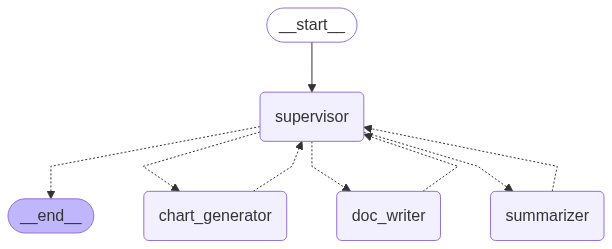

In [41]:
report_app

In [18]:
message = [HumanMessage(content="Here's a comparison of today's performance for NVIDIA (NVDA) and Microsoft (MSFT):\n\n**NVIDIA (NVDA):**\n- **Closed at:** $157.25 (down $1.10 from open)\n- **Intraday range:** $157.77 (low) to $160.98 (high)\n- **Performance:** Declined slightly from the day's high to close, with a narrower intraday range.\n\n**Microsoft (MSFT):**\n- **Closed at:** $491.09 (down $2.41 from open)\n- **Intraday range:** $493.44 (low) to $500.12 (high)\n- **Performance:** Experienced a sharper decline from its high ($500.12) to close, with a wider intraday range.\n\n**Key Insight:**  \nBoth stocks closed lower than their opening prices. Microsoft saw a larger drop in closing price (-0.49%) compared to NVIDIA (-0.69%), but NVIDIA had a steeper decline from its high to close. Microsoft's stock traded at higher price levels overall.")]

for s in report_app.stream({'messages':message}):
    print(s)
    print("-----")

<-- Supervisor Node -->
{'supervisor': {'next': 'summarizer'}}
-----
<-- Summarizer & Formatter Node -->
summarize_and_formatter
{'summarizer': {'messages': [HumanMessage(content='Here is the well-structured document summarizing the comparison between NVIDIA (NVDA) and Microsoft (MSFT) based on their daily stock performance:\n\n---\n\n# NVIDIA (NVDA) vs. Microsoft (MSFT): Daily Stock Performance Comparison\n\nThis document provides a detailed analysis of the stock performance for NVIDIA (NVDA) and Microsoft (MSFT) on the current trading day. Key metrics include closing prices, intraday ranges, and performance trends, culminating in a comparative summary.\n\n---\n\n## NVIDIA (NVDA): Daily Performance\n\n- **Closing Price:** NVIDIA closed at **$157.25**, reflecting a **$1.10 decrease** from its opening price.\n- **Intraday Range:** The stock traded between **$157.77 (low)** and **$160.98 (high)**, indicating a relatively narrow range of price movement.\n- **Performance Trend:**\n  - The 

### Head Supervisor

In [42]:
members=['research_team', 'report_team']
system_prompt = """
You are the **Head Supervisor Agent**, responsible for orchestrating two specialized teams: {members}.

Your core task is to **efficiently delegate** user queries to the correct team and ensure the workflow progresses logically.

---

## Team Responsibilities 🤝

* **Research Team:** Gathers, searches, and summarizes information based on user queries.
* **Report Team:** Generates structured outlines, writes, edits, and formats documents based on research outputs.

---

## Workflow Guidelines & Routing Logic 🔄

1.  **Initial Research:** For *any user query requiring information gathering or analysis*, you **must first route to the `research_team`**. This is the mandatory starting point for all research-based tasks.
2.  **Report Generation:** Once the `research_team` has completed its task and provided output, you **must then route to the `report_team`**. The report team is always called after successful research, regardless of the specific research content.
3.  **Completion:** Only after **both** the `research_team` and the `report_team` have successfully completed their respective tasks, you **must respond with `FINISH`**.
4.  **No Deviation:** Adhere strictly to these steps. Do not skip any mandatory routes, invent new tasks, or attempt to perform team functions yourself.
5.  **Direct Completion:** If a user message is casual, rhetorical, a greeting, or **clearly does not require any research or report generation**, directly respond with `FINISH`.

---

## Your Decision Output 🚦

Based on the current state of the workflow and the guidelines above, **your decision must be one of the following exact keywords**:

* `research_team`
* `report_team`
* `FINISH`
"""

head_supervisor = make_supervisor_node(openai_llm,members,system_prompt)

In [43]:
def call_research_team(state:State)->Command[Literal['supervisor']]:
    print('<-- Calling Research Team -->')
    response = research_app.invoke({'messages':state['messages']})
    print(response['messages'][-1].content)
    new_messages = state['messages'] + [HumanMessage(content=response['messages'][-1].content, name='research_team')]
    return Command(
        goto='supervisor',
        update={'messages':new_messages}
    )
    
def call_report_team(state:State)->Command[Literal['supervisor']]:
    print('<-- Calling Report Team -->')
    response = report_app.invoke({'messages':state['messages']})
    new_messages = state['messages'] + [HumanMessage(content=response['messages'][-1].content, name='report_team')]
    return Command(
        goto='supervisor',
        update={'messages':new_messages}
    )

In [44]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
## Build Graph
super_builder = StateGraph(State)
super_builder.add_node('supervisor',head_supervisor)
super_builder.add_node('research_team', call_research_team)
super_builder.add_node('report_team', call_report_team)

#Logic
super_builder.add_edge(START,'supervisor')

## Compile
research_report_app = super_builder.compile(checkpointer=memory)

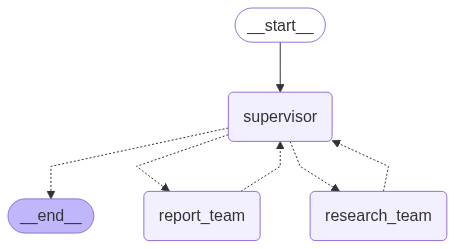

In [36]:
from IPython.display import Image, display

display(Image(research_report_app.get_graph().draw_mermaid_png()))

# Multi-Agent Architecture

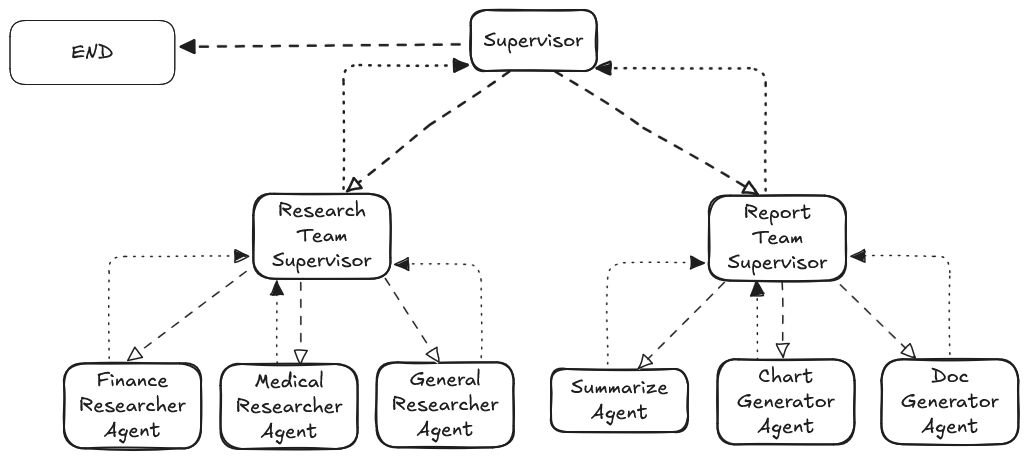

## First Result



In [23]:
config = {'configurable':{'thread_id':'1'}}
message = [HumanMessage(content='How did Apple stock performed today in comparision to Microsoft')]
for s in research_report_app.invoke({'messages':message}, config=config):
    print(s)
    print("-----------")

<-- Supervisor Node -->
<-- Calling Research Team -->
<-- Supervisor Node -->
<-- Finance Researcher -->
{'messages': [HumanMessage(content='How did Apple stock performed today in comparision to Microsoft', additional_kwargs={}, response_metadata={}, id='ea609a82-12f5-45ce-8550-a1ee63673b85')], 'next': 'finance_researcher'}
<-- Supervisor Node -->
**Financial Analysis: Apple (AAPL) vs. Microsoft (MSFT) - Daily Performance Comparison**

---

### **1. Stock Price Performance (Day-to-Day Metrics)**
| Metric                  | **Apple (AAPL)**       | **Microsoft (MSFT)**     | **Comparison**                     |
|-------------------------|------------------------|--------------------------|-------------------------------------|
| **Day Open**            | $212.15                | $493.50                  | Apple opened ~0.14% higher than MSFT |
| **Day Close**           | $212.44                | $491.10                  | Apple closed ~0.48% higher than MSFT |
| **Day High**            

In [24]:
config = {'configurable':{'thread_id':'1'}}
message = [HumanMessage(content='What are new researches happening in the field of agentic ai')]
for s in research_report_app.invoke({'messages':message}, config=config):
    print(s)
    print("-----------")

<-- Supervisor Node -->
<-- Calling Research Team -->
<-- Supervisor Node -->
<-- General Researcher -->
<-- Supervisor Node -->
Here's an overview of **new research in agentic AI** (autonomous AI agents with goal-directed behavior) as of mid-2024, based on recent academic and industry advancements:

---

### **1. Autonomous AI Agents in Dynamic Environments**
- **Meta’s "AgentNet" Framework** (2024):  
  Meta introduced **AgentNet**, a modular architecture for agents that integrates large language models (LLMs) with real-time decision-making systems. It enables agents to handle multi-step tasks (e.g., booking flights, coding) by breaking tasks into substeps and using environment feedback.  
  - **Key Innovation**: Combines LLMs with **reactive controllers** for real-time action, such as interacting with UIs or APIs.  
  - **Application**: Tested in browser-based environments (e.g., booking systems) and open-world games like *Minecraft*.

- **Google DeepMind’s "WebAgent" (2024)**:  
  

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `qwen/qwen3-32b` in organization `org_01jnqr8ja4f618x9hbqq7pxcwj` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 7595, Requested 5018. Please try again in 1m6.137s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [37]:
config = {'configurable':{'thread_id':'2'}}
message = [HumanMessage(content='I am having cold and headach, what does these symtoms suggent and what medication I can take?')]
for s in research_report_app.invoke({'messages':message}, config=config):
    print(s)
    print("-----------")

<-- Supervisor Node -->
<-- Calling Research Team -->
<-- Supervisor Node -->
<-- Medical Researcher -->
<-- Supervisor Node -->
**Summary of Findings:**

### **Symptoms and Causes**  
Your symptoms (cold and headache) are most likely due to a **common cold**, a viral upper respiratory tract infection (URTI) commonly caused by rhinoviruses. The cold is characterized by:  
- Nasal congestion, rhinorrhea, sneezing  
- Pharyngitis, cough  
- Occasional headache, low-grade fever, or malaise  

Headaches during colds may result from nasal sinus congestion, dehydration, or systemic inflammation. Viral infections trigger immune responses that can lead to vasodilation and pain perception changes.

---

### **Treatment Recommendations**  
#### **1. Over-the-Counter (OTC) Medications**  
For headache and cold symptoms, consider:  
- **Acetaminophen (Tylenol)** or **ibuprofen (Advil, Motrin):**  
  - Effective for reducing fever, headache, and body aches.  
  - Avoid aspirin in children/teens due

<-- Supervisor Node -->
<-- Calling Research Team -->
<-- Supervisor Node -->
<-- Medical Researcher -->
<-- Supervisor Node -->
### **Latest Advancements in CRISPR (2023–2024)**  
**Summary:**  
1. **Clinical Trials**:  
   - **CRISPR-Cas9 Therapies**:  
     - **Exa-cel (Casgevy)**: Approved by the FDA in 2023 for sickle cell disease and beta-thalassemia, showing durable correction of red blood cell production in clinical trials. A phase III trial (NCT05635524) in 2024 demonstrated 90% patient independence from blood transfusions.  
     - **CTX001**: CRISPR Therapeutics and Vertex Pharmaceuticals reported phase III results (2024) for CTX001 in treating hemoglobinopathies, with 95% of patients achieving treatment-free status.  
   - **In Vivo Applications**:  
     - **Intellia Therapeutics**: A phase I trial (NCT05336272) using lipid nanoparticles (LNPs) to deliver CRISPR-Cas9 for treating transthyretin amyloidosis showed a 50% reduction in mutant protein levels.  

2. **Base Editin

Python REPL can execute arbitrary code. Use with caution.


python_repl_tool


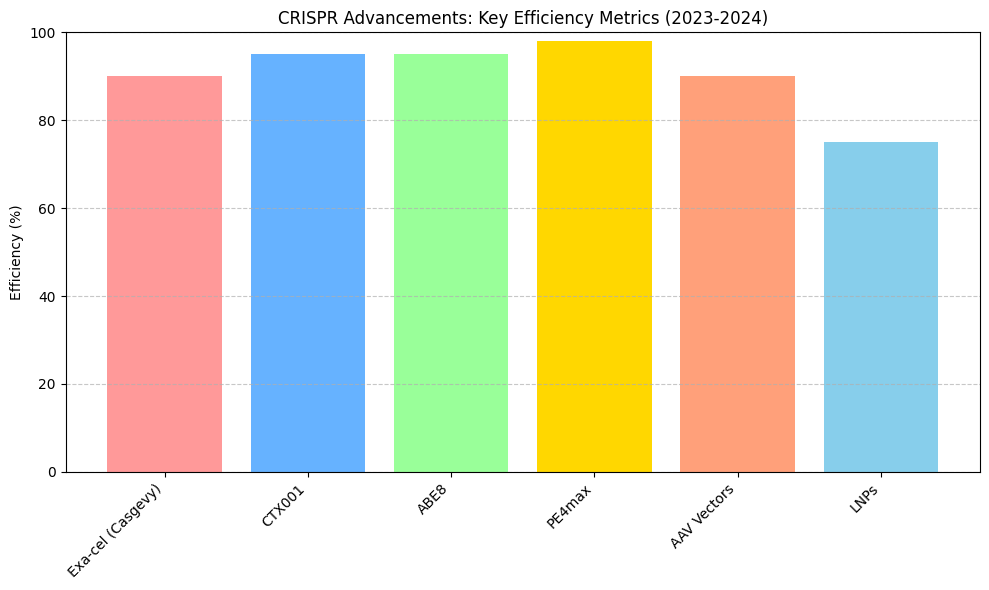

<-- Supervisor Node -->
<-- Supervisor Node -->
messages
-----------
next
-----------


In [45]:
config = {'configurable':{'thread_id':'2'}}
message = [HumanMessage(content='What are the latest advancements in CRISPR? Generate a report with summary and then generate a chart.')]
for s in research_report_app.invoke({'messages':message}, config=config):
    print(s)
    print("-----------")